### Thank you for opening this notebook.
I am going to explain what I did in this competition through this 3 months. <br>
Yes, I was in this competition since the beginning. <br>
This is the first competition I was fully committed.<br>
<br>
I did everything on this one notebook. Training and inference.<br>
So if you see this notebook, you will know everything what I did.<br>
<br>
As I am just a ML beginner, I really appreciate your feedbacks! Please don't hesitate pointing out any falters or things to be improved you found.<br>
Thank you!<br>

### The result
- public : 0.01816 : 24th
- private: 0.01605 : 14th

## The strategy
**Overfit to private.**<br>
<br>
Some of the method done in this notebook won't work in the real problem. Like using test set for PCA or Variance Threshold. <br>
But for this competition, I used them on purpose, hoping it works for private LB. <br>
I wasn't sure it works or not at all. <br>

## Prediction Flow Summary
1. Make prediction with 5 models
 1. Simple NN with DenoisingAutoEncoder
 1. ResNet
 1. 2 Headed NN ( I don't know how it should be called
 1. RNN
 1. TabNet
1. Stack all of them
1. Blend all these '6' models

The "magic" part was in blending. I blended all results including stacking result. <br>
Even though all these 6 models gave me the LB score 0.0185-ish, this blending gave me the LB score of 0.0182-ish.<br>
I've never seen someone did this before, that's why I was not confident at all.<br>
Intuitively, it offers much 'overfit' to CV. Please correct me if I'm wrong.<br>
<br>
And if this method has some kind of specific name, please make a comment.<br>
<br>

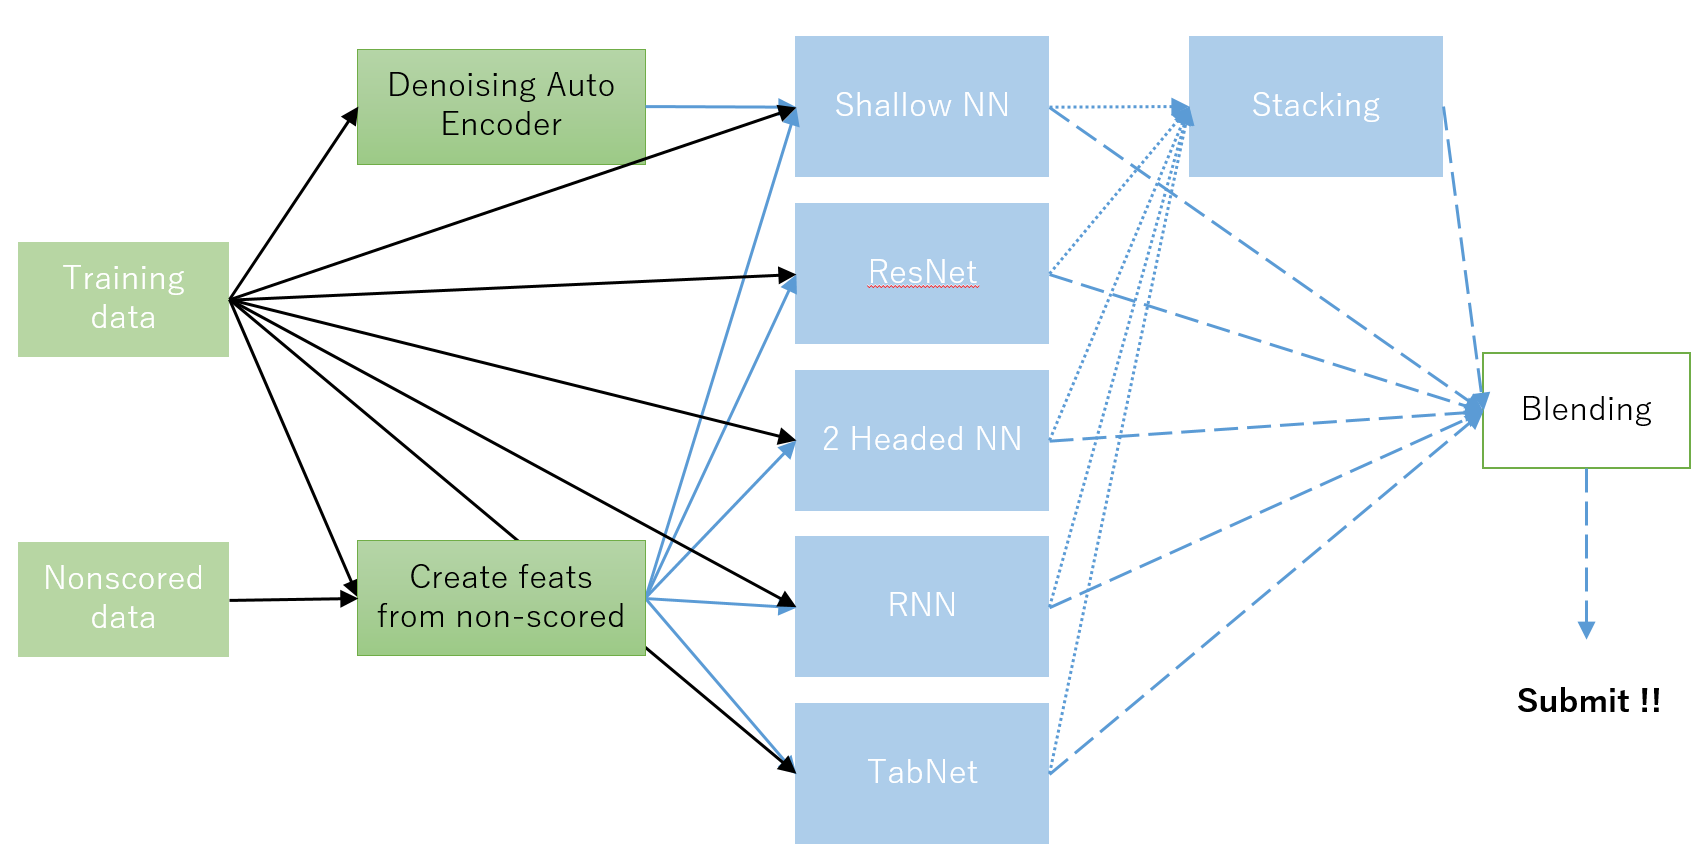

## Other things to consider
- Validation<br>
  I used MultilabelStratifiedKFold for the final submission as it gave me a better LB all the time. <br>
  Also in my case, the drug id based CV didn't correlate to LB that much either. So I decided to use it. <br>
  Well, I know validation strategy is quite important, but I really don't know what was the right validation scheme. <br>
  I'm looking forward to see others solutions.<br>
- Hyper parameter tuning<br>
  I spent most of the time to tune each models. <br>
  I don't have any knowledge in MoA. Even after I read many explanations, I didn't know how to utilize these...<br>
  I tuned models seeing OOF score. I didn't know the CV works or not, but it seems it worked after all. ...maybe just luckey. <br>

## Acknowledgement
I learned a lot from public notebooks and discussions.<br><br>
My solution is hugely influenced by them. <br>
Please do upvote them, all of them are super! <br>
- Notebooks
  - [MoA Stacked TabNet Baseline [Tensorflow 2.0]](https://www.kaggle.com/gogo827jz/moa-stacked-tabnet-baseline-tensorflow-2-0)
  - [MoA LSTM / Pure Transformer [fast and NOT bad]](https://www.kaggle.com/gogo827jz/moa-lstm-pure-transformer-fast-and-not-bad)
  - [MoA: Multi Input ResNet Model](https://www.kaggle.com/rahulsd91/moa-multi-input-resnet-model)
  - [Keras autoencoder (DAE) + neural network starter](https://www.kaggle.com/isaienkov/keras-autoencoder-dae-neural-network-starter)
  - [MoA - Tensorflow Fast Convergence](https://www.kaggle.com/tolgadincer/moa-tensorflow-fast-convergence)
  - [keras Multilabel Neural Network v1.2](https://www.kaggle.com/simakov/keras-multilabel-neural-network-v1-2).

I also have to mention some discussions which helped me much.
- Discussions
  - [After label smoothing, my CV matches my LB. Is this a coincidence?](https://www.kaggle.com/c/lish-moa/discussion/185593)<br>
    As everybody notices, this label smoothing offered us big jump.
  - [A method to smart-initialize the final layers of NNs](https://www.kaggle.com/c/lish-moa/discussion/185161)<br>
    It allows all of my models converge much faster. As I included all the training part in this notebook, making them faster is one of my challenge.
  - [A Tip on Parameter Tuning for Beginners](https://www.kaggle.com/c/lish-moa/discussion/190838)<br>
    Thanks to his tip, I can make much experiments faster.
    
And everybody participated in this competition. <br>
I learned reeeeally a lot! <br>

## Options
I used basically 2 seeds, 7 splits for each models to train and infer. <br>
I provide specific seeds but it doesn't matter. I was just not comfortable with using 1, 2, 3 kind of consective numbers.<br>
DAE and Stacking has 3 seeds. I wanted to exploit the limitation, 2 hours of running time. <br>
I added seeds as much as I can. <br>
<br>
About batch size, I selected basically 64 for all the models. Only RNN uses 128, as it is very slow. I needed to make it faster even though it hurts the score a bit.<br>

In [ ]:
LABEL_SMOOTHING=0.001

SEEDS = [120,2524]
SPLITS = 7
BATCH_SIZE = 64
EPOCHS = 60

VARIANCE_THRESHOLD = True

ADD_NON_TRAIN = True
ADD_SEEDS = SEEDS
ADD_SPLITS = SPLITS
ADD_BATCH_SIZE = BATCH_SIZE

ADD_EPOCHS = EPOCHS

RUN_SNN = True
SNN_SEEDS = SEEDS + [42]
SNN_SPLITS = SPLITS
SNN_BATCH_SIZE = BATCH_SIZE
SNN_EPOCHS = EPOCHS

RUN_NN = True
NN_SEEDS = SEEDS 
NN_SPLITS = SPLITS
NN_BATCH_SIZE = BATCH_SIZE
NN_EPOCHS = EPOCHS

RUN_NN2 = True
NN2_SEEDS = SEEDS
NN2_SPLITS = SPLITS
NN2_BATCH_SIZE = BATCH_SIZE
NN2_EPOCHS = EPOCHS

RUN_RNN = True
RNN_SEEDS = SEEDS
RNN_SPLITS = SPLITS
RNN_BATCH_SIZE = 128
RNN_EPOCHS = EPOCHS

RUN_TABNET = True
TAB_SEEDS = SEEDS
TAB_SPLITS = SPLITS
TAB_BATCH_SIZE = BATCH_SIZE
TAB_EPOCHS = EPOCHS

RUN_STACKING = True
STK_SEEDS = SEEDS + [42]
STK_SPLITS = SPLITS 
STK_EPOCHS = EPOCHS
STK_BATCH_SIZE = BATCH_SIZE

RE_RUN_NN = True
RE_NN_SEEDS = SEEDS

In [ ]:
import pandas as pd
import numpy as np
import random
import os

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [ ]:
import sys
sys.path.append('../input/interactivestratification/iterative-stratification-master')
sys.path.append('../input/pytorchtabnet/tabnet-develop')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from pytorch_tabnet import tab_network

In [ ]:
from sklearn.metrics import log_loss
import torch

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)  
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

def swish(x):
    return x * K.sigmoid(x)

def show_metrics(valid_preds, show_each=True):
    metrics = []
    for _target in valid_preds.columns:
      logloss = log_loss(train_targets_scored.iloc[:,1:].loc[:, _target], valid_preds.loc[:, _target])
      metrics.append(logloss)
      if show_each:
        print(f'column: {_target}, log loss: {logloss}')
    print(f'OOF Metric: {np.mean(metrics)}')

    return metrics

In [ ]:
train_features = pd.read_csv(f'../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv(f'../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv(f'../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv(f'../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv(f'../input/lish-moa/sample_submission.csv')

In [ ]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

## Feature Engineering 
- Variance Threshold<br>
There are 2 Variance Thresholds, leaky and non-leaky. Meaning of 'leaky' here is, using test set or not. I intentionally included test set, expecting overfit to private. <br>
Leaky Variance Threshold is applied to all the training and test sets except for RNN. Only RNN uses non-leaky Variance Threshold. I will explain the reason in the RNN section.
- PCA features<br>
Leaky again, I used test set as well.<br>
I made 2 types of PCA features. More n_comp feats and less n_comp feats. For genes and cells respectivelly. 
- Statistical features<br>
I made these features for the following features, genes + cells and genes only.<br>
'sum', 'mean', 'std', 'skew', 'kurt', 'median'
- Rank Gauss, Standard Scaler <br>
I applied both of them to the features.
- Non scored targets<br>
I used the non scored train targets to include the training set. <br>
The way I used this is, as additional features.<br>
Some features in the non scored targets don't have much positive values. Some of them have no positive values. So I omitted these features. <br>
To use this features, as the this non scored targets are not provided for test set, I had to create the features for test set. <br>
To do this, I made a model to create non scored targets for test set. <br>
The details are explained in the "Make Extra Features from Non-Scored Targets" part.

In [ ]:
_X_train = train_features.copy()
_X_test = test_features.copy()
_y_train = train_targets_scored.copy()

In [ ]:
from sklearn.feature_selection import VarianceThreshold

if VARIANCE_THRESHOLD:
    vt_cols = _X_train.loc[:,GENES+CELLS].columns

    vh = VarianceThreshold(0.8)
    train_trans = pd.DataFrame(vh.fit_transform(_X_train.loc[:,GENES+CELLS]))
    vt_cols = vt_cols[vh.get_support()]


    vt_cols_leaky = _X_train.loc[:,GENES+CELLS].columns

    vh_leaky = VarianceThreshold(0.8)
    train_trans = pd.DataFrame(vh_leaky.fit_transform(pd.concat([_X_train.loc[:,GENES+CELLS], _X_test.loc[:,GENES+CELLS]])))
    vt_cols_leaky = vt_cols_leaky[vh_leaky.get_support()]

In [ ]:
def deal_with_cp_type(_X_train, _X_test):
    train_trt_index = _X_train.cp_type == 'trt_cp'
    test_trt_index = _X_test.cp_type == 'trt_cp'

    _X_train = _X_train[train_trt_index]
    _X_test = _X_test
    del _X_train['cp_type']
    del _X_test['cp_type']

    return _X_train, _X_test, train_trt_index, test_trt_index

_X_train, _X_test, train_trt_index, test_trt_index = deal_with_cp_type(_X_train, _X_test)


def deal_with_cp_dose(_X_train, _X_test):
    _X_train = pd.concat([_X_train, pd.get_dummies(_X_train.cp_dose)], axis=1)
    del _X_train['cp_dose']
    _X_test = pd.concat([_X_test, pd.get_dummies(_X_test.cp_dose)], axis=1)
    del _X_test['cp_dose']

    return _X_train, _X_test

_X_train, _X_test = deal_with_cp_dose(_X_train, _X_test)


def deal_with_sig_id(_X_train, _X_test):
    del _X_train['sig_id']
    del _X_test['sig_id']

    return _X_train, _X_test

_X_train, _X_test = deal_with_sig_id(_X_train, _X_test)


def deal_with_y(_y_train, train_trt_index):
    _y_train = _y_train[train_trt_index]
    del _y_train['sig_id']

    return _y_train

_y_train = deal_with_y(_y_train, train_trt_index)

# I guess 'D1' should be eliminated but anyway, I was using it. 

BASE_COLS = ['cp_time', 'D1', 'D2']

_X_train_dae = _X_train.copy()
_X_test_dae = _X_test.copy()

In [ ]:
_X_train = _X_train.reset_index()

In [ ]:
non_scored_ones = pd.DataFrame()
non_scored_ones['col_name'] = ''
non_scored_ones['item_counts'] = 0

for col in train_targets_nonscored.columns[1:]:

    item_counts = len(train_targets_nonscored[train_targets_nonscored[col] == 1])

    non_scored_ones = non_scored_ones.append({'col_name':col, 'item_counts':item_counts}, ignore_index=True)

non_scored_target_cols = non_scored_ones[non_scored_ones.item_counts > 10].col_name

y_non_train = train_targets_nonscored[non_scored_target_cols]
y_non_train = y_non_train[train_trt_index].reset_index(drop=True)

In [ ]:
from sklearn.decomposition import PCA

def yield_pca(_X_train, _X_test, prefix, decomp_cols, comp=50, random_state=42):
    pca = PCA(n_components=comp, random_state=random_state)
    pca.fit(pd.concat([_X_train.loc[:,decomp_cols], _X_test.loc[:,decomp_cols]]))
    _X_train_PCA = pca.transform(_X_train[decomp_cols])
    _X_test_PCA = pca.transform(_X_test[decomp_cols])

    _X_train_PCA = pd.DataFrame(_X_train_PCA, columns=[f'pca_{prefix}-{i}' for i in range(comp)])
    _X_test_PCA = pd.DataFrame(_X_test_PCA, columns=[f'pca_{prefix}-{i}' for i in range(comp)])

    return _X_train_PCA, _X_test_PCA

_X_train_G_PCA, _X_test_G_PCA = yield_pca(_X_train, _X_test, 'G', GENES, 90)
_X_train_C_PCA, _X_test_C_PCA = yield_pca(_X_train, _X_test, 'C', CELLS, 27)
_X_train_G_PCA_Dense, _X_test_G_PCA_Dense = yield_pca(_X_train, _X_test, 'Gd', GENES, 8)
_X_train_C_PCA_Dense, _X_test_C_PCA_Dense = yield_pca(_X_train, _X_test, 'Cd', CELLS, 1)

_X_train = pd.concat([_X_train, _X_train_G_PCA], axis=1)
_X_train = pd.concat([_X_train, _X_train_C_PCA], axis=1)
_X_train = pd.concat([_X_train, _X_train_G_PCA_Dense], axis=1)
_X_train = pd.concat([_X_train, _X_train_C_PCA_Dense], axis=1)

_X_test = pd.concat([_X_test, _X_test_G_PCA], axis=1)
_X_test = pd.concat([_X_test, _X_test_C_PCA], axis=1)
_X_test = pd.concat([_X_test, _X_test_G_PCA_Dense], axis=1)
_X_test = pd.concat([_X_test, _X_test_C_PCA_Dense], axis=1)

# cols
PCA_G = [col for col in _X_train.columns if col.startswith('pca_G-')] + [col for col in _X_train.columns if col.startswith('pca_Gd-')]
PCA_C = [col for col in _X_train.columns if col.startswith('pca_C-')] + [col for col in _X_train.columns if col.startswith('pca_Cd-')]

In [ ]:
def make_feature(data, target_feats, create, prefix):
    target_data = data.loc[:,target_feats]
    invoker = getattr(target_data, create)
    return pd.DataFrame(invoker(axis=1), columns=[f'{prefix}_{create}'])

for method in ['sum', 'mean', 'std', 'skew', 'kurt', 'median']: # min max
    _X_train = pd.concat([_X_train, make_feature(_X_train, GENES+CELLS, method, 'gce')], axis = 1)
    _X_train = pd.concat([_X_train, make_feature(_X_train, GENES, method, 'ge')], axis = 1)

    _X_test = pd.concat([_X_test, make_feature(_X_test, GENES+CELLS, method, 'gce')], axis = 1)
    _X_test = pd.concat([_X_test, make_feature(_X_test, GENES, method, 'ge')], axis = 1)

GC_EX = [col for col in _X_train.columns if col.startswith('gce_')]# + [col for col in _X_train.columns if col.startswith('gce_')]
G_EX = [col for col in _X_train.columns if col.startswith('ge_')]# + [col for col in _X_train.columns if col.startswith('ge_')]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

train_col_names = _X_train.columns
test_col_names = _X_test.columns

TRANSFORM_TARGET_COLS = BASE_COLS + GENES + CELLS + PCA_G + PCA_C + G_EX + GC_EX


def rank_gauss(_X_train, _X_test, cols=TRANSFORM_TARGET_COLS, random_state=42):
    qt = QuantileTransformer(random_state=random_state, output_distribution='normal')
    qt.fit(pd.concat([_X_train[cols], _X_test[cols]]))
    _X_train[cols] = qt.transform(_X_train[cols])
    _X_test[cols] = qt.transform(_X_test[cols])

    return _X_train, _X_test


def standard_scaler(_X_train, _X_test, cols=TRANSFORM_TARGET_COLS):
    ss = StandardScaler()
    ss.fit(pd.concat([_X_train[cols], _X_test[cols]]))
    _X_train[cols] = ss.transform(_X_train[cols])
    _X_test[cols] = ss.transform(_X_test[cols])

    return _X_train, _X_test

_X_train, _X_test = rank_gauss(_X_train, _X_test)
_X_train, _X_test = standard_scaler(_X_train, _X_test)

_X_train.columns = train_col_names
_X_test.columns = test_col_names

In [ ]:
if VARIANCE_THRESHOLD:
    vt_cols = vt_cols.values.tolist() + BASE_COLS + PCA_G + PCA_C + GC_EX + G_EX

    _X_train_nl = pd.concat([_X_train.iloc[:,:1], _X_train.loc[:,vt_cols]], axis=1)
    _X_test_nl = _X_test.loc[:,vt_cols]
    
        
    vt_cols_leaky = vt_cols_leaky.values.tolist() + BASE_COLS + PCA_G + PCA_C + GC_EX + G_EX

    _X_train = pd.concat([_X_train.iloc[:,:1], _X_train.loc[:,vt_cols_leaky]], axis=1)
    _X_test = _X_test.loc[:,vt_cols_leaky]

    GENES = [col for col in _X_train.columns if col.startswith('g-')]
    CELLS = [col for col in _X_train.columns if col.startswith('c-')]

In [ ]:
_X_train = _X_train.set_index('index')
X_train = _X_train.copy()
X_test = _X_test.copy()

_X_train_nl = _X_train_nl.set_index('index')
X_train_nl = _X_train_nl.copy()
X_test_nl = _X_test_nl.copy()

y_train = _y_train.copy()

In [ ]:
import time

def train_and_predict(name, model_func, _X_i_train, _y_i_train, _X_i_test, orig_targets, result_template,
                      seeds, splits, epochs, batch_size, shuffle_rows=False, pick_col_size=800, 
                      do_show_metrics=True, show_each_metrics=True):
    st = time.time()

    is_list = isinstance(_X_i_train, list)

    val_result = orig_targets.copy()
    val_result.loc[:, :] = 0

    sub_result = result_template.copy()
    sub_result.loc[:, 1:] = 0

    for h, seed in enumerate(seeds):

        seed_everything(seed)

        for i, (train_idx, valid_idx) in enumerate(MultilabelStratifiedKFold(n_splits=splits, random_state=seed, shuffle=True)
                                        .split(_y_i_train, _y_i_train)):
            print(f'Fold {i+1}')

            if is_list:
                _X_train = [_X_i_train[0].loc[:,:].values[train_idx], _X_i_train[1].loc[:,:].values[train_idx]]
                _X_valid = [_X_i_train[0].loc[:,:].values[valid_idx], _X_i_train[1].loc[:,:].values[valid_idx]]
            else:
                _X_train = _X_i_train.loc[:,:].values[train_idx]
                _X_valid = _X_i_train.loc[:,:].values[valid_idx]

            _y_train = _y_i_train.values[train_idx]
            _y_valid = _y_i_train.values[valid_idx]

            if is_list:
                model = model_func(len(_X_i_train[0].columns), len(_X_i_train[1].columns))
            else:
                model = model_func(len(_X_i_train.columns))
            
            model.fit(_X_train, _y_train,
                    validation_data=(_X_valid, _y_valid),
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[
                        ReduceLROnPlateau(monitor='val_logloss', factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='min')
                        , ModelCheckpoint(f'{name}_{seed}_{i}.hdf5', monitor = 'val_logloss', verbose = 0, save_best_only = True, save_weights_only = True, mode = 'min')
                        , EarlyStopping(monitor = 'val_logloss', min_delta = 1e-4, patience = 5, mode = 'min', baseline = None, restore_best_weights = True)
                    ], verbose=2)
        
            model.load_weights(f'{name}_{seed}_{i}.hdf5')
            val_result.iloc[_y_i_train.iloc[valid_idx,:].index.values, :] += model.predict(_X_valid)

            if is_list:
                sub_result.loc[test_trt_index, sub_result.columns[1:]] += model.predict([_X_i_test[0].loc[test_trt_index, :], _X_i_test[1].loc[test_trt_index, :]])
            else:
                sub_result.loc[test_trt_index, sub_result.columns[1:]] += model.predict(_X_i_test.loc[test_trt_index, :])

            print('')

        tmp_result = val_result.copy()
        tmp_result.iloc[:,1:] = val_result.iloc[:,1:] / (h + 1)
        print(f' ---- seed:{seed}, ensemble:{h + 1}')
        if do_show_metrics:
            _ = show_metrics(tmp_result, show_each=False)

    val_result.iloc[:,1:] = val_result.iloc[:,1:] / len(seeds)
    if do_show_metrics:
        metrics = show_metrics(val_result, show_each=show_each_metrics)
    else:
        metrics = None

    sub_result.iloc[:, 1:] = sub_result.iloc[:, 1:] / (len(seeds) * splits)

    print(f' elapsed: {time.time() - st}')

    return sub_result, val_result, metrics

## Make Extra Features from Non-Scored Targets
To use non scored targets, I made a model and created non scored targets for test set. <br>

In [ ]:
p_min = 0.001
p_max = 0.999

def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,p_min,p_max)
    return -K.mean(y_true*K.log(y_pred) + (1-y_true)*K.log(1-y_pred))

In [ ]:
output_bias=tf.keras.initializers.Constant(-np.log(y_train.mean(axis=0).to_numpy()))

In [ ]:
def create_add_model(input_dim):
    print(f'the input dim is {input_dim}')

    model = M.Sequential()
    model.add(L.Input(input_dim))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(WeightNormalization(L.Dense(input_dim, activation='elu')))

    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.4))
    model.add(WeightNormalization(L.Dense(512, activation='selu')))

    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(WeightNormalization(L.Dense(y_non_train.shape[1], activation='sigmoid',
                                          bias_initializer=tf.keras.initializers.Constant(-np.log(y_non_train.mean(axis=0).to_numpy())
                                          ))))

    model.compile(optimizer=tfa.optimizers.Lookahead(tf.optimizers.Adam(lr=1e-3), sync_period=10),
                loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING), metrics=logloss)

    return model

In [ ]:
non_scored_template = sample_submission.copy()
non_scored_template = pd.DataFrame(non_scored_template.pop('sig_id'))
for col in non_scored_target_cols:
    non_scored_template[col] = 0.

In [ ]:
if ADD_NON_TRAIN:
    add_result, add_valid_preds, add_metrics = train_and_predict('ADD', create_add_model, X_train, y_non_train, X_test,
                                                                 train_targets_nonscored[non_scored_target_cols].loc[train_trt_index,:], non_scored_template,
                                                                  ADD_SEEDS, ADD_SPLITS, ADD_EPOCHS, ADD_BATCH_SIZE, shuffle_rows=False, do_show_metrics=False, show_each_metrics=False)

In [ ]:
if ADD_NON_TRAIN:
    X_non_train = add_valid_preds.copy()
    X_non_test = add_result.iloc[:,1:].copy()
    cols = X_non_train.columns
    
    X_non_train, X_non_test = rank_gauss(X_non_train, X_non_test, cols)
    X_non_train, X_non_test = standard_scaler(X_non_train, X_non_test, cols)

## Shallow NN with DenoisingAutoEncoder
For this model for the starter, make 2048 features using denoising auto encoder. <br>
Then reduce the features using Variance Threshold. 2048 is too much too handle. <br>
The reason why I made 2048 features is, even 2048 is too much, it seemed that it succeeded to express denoising better than other number of units. <br>
Then make PCA feats, apply rank gauss and standard scaler, then make pediction.

In [ ]:
def create_autoencoder(input_dim):
    input_vector = L.Input(shape=(input_dim,))
    encoded = L.Dense(1024, activation='elu')(input_vector)
    encoded = L.Dense(2048, activation='elu')(encoded)
    decoded = L.Dense(1024, activation='elu')(encoded)
    decoded = L.Dense(input_dim, activation='elu')(decoded)
    
    autoencoder = M.Model(input_vector, decoded)
    autoencoder.compile(optimizer=tf.optimizers.Adam(lr=0.0012, amsgrad=True), loss='mse')
    
    return autoencoder

In [ ]:
mu, sigma = 0, 0.1

seed_everything(128)

dae_train = pd.concat([_X_train_dae, _X_test_dae])

noise = np.random.normal(mu, sigma, [dae_train.shape[0], dae_train.shape[1]]) 
noised_train = dae_train + noise

autoencoder = create_autoencoder(dae_train.shape[1])

autoencoder.fit(noised_train, dae_train,
                epochs=500,
                batch_size=128,
                callbacks=[
                    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience = 3, verbose=1, min_delta=1e-4, mode='min')
                    , ModelCheckpoint(f'dae.hdf5', monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only = True, mode = 'min')
                    , EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 8, mode = 'min', baseline = None, restore_best_weights = True)],
                shuffle=True,
                validation_split=0.2)

autoencoder.load_weights(f'dae.hdf5')
#138/138 [==============================] - 1s 10ms/step - loss: 0.6584 - val_loss: 0.6722
#138/138 [==============================] - 1s 10ms/step - loss: 0.6576 - val_loss: 0.6714

In [ ]:
#163/163 [==============================] - 1s 6ms/step - loss: 0.6668 - val_loss: 0.6222
encoder = M.Model(autoencoder.input, autoencoder.layers[2].output)
__X_train_dae = pd.DataFrame(encoder.predict(_X_train_dae))
__X_test_dae = pd.DataFrame(encoder.predict(_X_test_dae))

In [ ]:
vh_dae = VarianceThreshold(0.2)
vh_dae.fit_transform(pd.concat([__X_train_dae, __X_test_dae]))
dae_cols = __X_train_dae.columns[vh_dae.get_support()]
print(len(dae_cols))

X_train_dae = __X_train_dae.loc[:, dae_cols]
X_test_dae = __X_test_dae.loc[:, dae_cols]

In [ ]:
X_train_dae = pd.concat([X_train_dae, X_non_train.reset_index(drop=True)], axis=1)
X_test_dae = pd.concat([X_test_dae, X_non_test.reset_index(drop=True)], axis=1)

In [ ]:
_X_train_G_PCA_dae, _X_test_G_PCA_dae = yield_pca(_X_train, _X_test, 'Gd', GENES, 90, 128)
_X_train_C_PCA_dae, _X_test_C_PCA_dae = yield_pca(_X_train, _X_test, 'Cd', CELLS, 27, 128)

_X_train_G_PCA_Dense_dae, _X_test_G_PCA_Dense_dae = yield_pca(_X_train, _X_test, 'Gd', GENES, 8, 128)
_X_train_C_PCA_Dense_dae, _X_test_C_PCA_Dense_dae = yield_pca(_X_train, _X_test, 'Cd', CELLS, 1, 128)

X_train_dae = pd.concat([X_train_dae, _X_train_G_PCA_dae, _X_train_C_PCA_dae, _X_train_G_PCA_Dense, _X_train_C_PCA_Dense_dae], axis=1)
X_test_dae = pd.concat([X_test_dae, _X_test_G_PCA_dae, _X_test_C_PCA_dae, _X_test_G_PCA_Dense, _X_test_C_PCA_Dense_dae], axis=1)

X_train_dae, X_test_dae = rank_gauss(X_train_dae, X_test_dae, X_train_dae.columns, random_state=128)
X_train_dae, X_test_dae = standard_scaler(X_train_dae, X_test_dae, X_train_dae.columns)

In [ ]:
def create_simple_nn(input_dim):
    print(f'the input dim is {input_dim}')

    model = M.Sequential()
    model.add(L.Input(input_dim))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(WeightNormalization(L.Dense(input_dim, activation='selu')))

    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(WeightNormalization(L.Dense(512, activation='swish')))

    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(WeightNormalization(L.Dense(206, activation='sigmoid', bias_initializer=output_bias)))

    model.compile(optimizer=tfa.optimizers.Lookahead(tf.optimizers.Adam(lr=0.01), sync_period=10),
                loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING), metrics=logloss)

    return model

In [ ]:
if RUN_SNN:
    snn_result, snn_valid_preds, snn_metrics = train_and_predict('SNN', create_simple_nn, X_train_dae, _y_train, X_test_dae,
                                                                 train_targets_scored.iloc[:,1:], sample_submission,
                                                                 SNN_SEEDS, SNN_SPLITS, SNN_EPOCHS, SNN_BATCH_SIZE, shuffle_rows=False)

## ResNet
Actually I don't know whether it still can be called as ResNet or not. I made many changes for the model.

In [ ]:
_X_train = pd.concat([X_train, X_non_train], axis=1)
_X_test = pd.concat([X_test, X_non_test], axis=1)

In [ ]:
sep_cols = BASE_COLS + GENES #+ CELLS
_X_train_1 = _X_train[sep_cols]
_X_train_2 = _X_train.drop(sep_cols,axis=1)

_X_test_1 = _X_test[sep_cols]
_X_test_2 = _X_test.drop(sep_cols,axis=1)

_X_train = [_X_train_1, _X_train_2]
_X_test = [_X_test_1, _X_test_2]

In [ ]:
def create_res_model(n_features, n_features_2):
    print(f'the input dim is {n_features}, {n_features_2}')

    input_1 = L.Input(shape = (n_features,), name = 'Input1')
    input_2 = L.Input(shape = (n_features_2,), name = 'Input2')

    head_1 = M.Sequential([
        L.BatchNormalization(),
        L.Dropout(0.3),
        L.Dense(512, activation='elu'), 
        L.BatchNormalization(),
        L.Dropout(0.5),
        L.Dense(256, activation='elu')
        ],name='Head1') 

    input_3 = head_1(input_1)
    input_3_concat = L.Concatenate()([input_2, input_3])

    head_2 = M.Sequential([
        L.BatchNormalization(),
        L.Dropout(0.3),
        L.Dense(n_features_2, activation='relu'),
        L.BatchNormalization(),
        L.Dropout(0.5),
        L.Dense(n_features_2, activation='elu'),
        L.BatchNormalization(),
        L.Dropout(0.5),
        L.Dense(256, activation='relu'),
        L.BatchNormalization(),
        L.Dropout(0.5),
        L.Dense(256, activation='selu')
        ],name='Head2')

    input_4 = head_2(input_3_concat)
    input_4_avg = L.Average()([input_3, input_4]) 

    head_3 = M.Sequential([
        L.BatchNormalization(),
        L.Dropout(0.3),
        L.Dense(256, activation='swish'),
        L.BatchNormalization(),
        L.Dense(256, activation='selu'),
        L.BatchNormalization(),
        L.Dense(206, activation='sigmoid')
        ],name='Head3')

    output = head_3(input_4_avg)


    model = M.Model(inputs = [input_1, input_2], outputs = output)
    model.compile(optimizer=tf.optimizers.Adam(lr=0.002),
                  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING), metrics=logloss)

    return model

In [ ]:
if RUN_NN:
    nn_result, nn_valid_preds, nn_metrics = train_and_predict('RES', create_res_model, _X_train, y_train, _X_test,
                                                              train_targets_scored.iloc[:,1:], sample_submission,
                                                              NN_SEEDS, NN_SPLITS, NN_EPOCHS, NN_BATCH_SIZE, shuffle_rows=False)

## Two Headed NN
I don't know how to call it either. Kindly point me out if there's name for it. <br>
For this NN, I separated the training data into 2 parts, cells and the others. <br>

In [ ]:
if ADD_NON_TRAIN:
    _X_train = []
    _X_train.append(X_train.copy())
    _X_train.append(X_non_train.copy())

    _X_test = []
    _X_test.append(X_test.copy())
    _X_test.append(X_non_test.copy())

# extract_cells = set(CELLS) - set(['c-22'])

# _X_train[0] = _X_train[0].drop(extract_cells, axis=1)
# _X_test[0] = _X_test[0].drop(extract_cells, axis=1)

_X_train[1] = pd.concat([_X_train[1], _X_train[0][CELLS]], axis=1)
_X_test[1] = pd.concat([_X_test[1], _X_test[0][CELLS]], axis=1)
_X_train[0] = _X_train[0].drop(CELLS, axis=1)
_X_test[0] = _X_test[0].drop(CELLS, axis=1)

In [ ]:
def create_twohead_model(input_dim1, input_dim2):
    print(f'the input dim is {input_dim1}, {input_dim2}')

    input_1 = L.Input(input_dim1)
    x1 = L.BatchNormalization()(input_1)
    x1 = L.Dropout(0.5)(x1)
    o1 = L.Dense(input_dim1, activation='elu')(x1)

    input_2 = L.Input(input_dim2)
    x2 = L.BatchNormalization()(input_2)
    x2 = L.Dropout(0.5)(x2)
    o2 = L.Dense(input_dim2, activation='elu')(x2)

    x = L.Concatenate()([o1, o2])

    x = L.BatchNormalization()(x)
    x = L.Dropout(0.4)(x)
    x = L.Dense(512, activation='selu')(x)
    
    x = L.BatchNormalization()(x)
    x = L.Dropout(0.5)(x)
    output = L.Dense(206, activation='sigmoid')(x)

    model = M.Model([input_1, input_2], output)

    model.compile(optimizer=tfa.optimizers.Lookahead(tf.optimizers.Adam(lr=0.01), sync_period=10),
                loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING), metrics=logloss)
    
    return model

In [ ]:
if RUN_NN2:
    nn2_result, nn2_valid_preds, nn2_metrics = train_and_predict('NN2', create_twohead_model, _X_train, y_train, _X_test,
                                                                 train_targets_scored.iloc[:,1:], sample_submission,
                                                                 NN2_SEEDS, NN2_SPLITS, NN2_EPOCHS, NN2_BATCH_SIZE, shuffle_rows=False)

## RNN
For RNN, I didn't use leaky feats. <br>
I found that feeding some specific features gives me a good result. <br>
On the other hand, if I apply Variance Threshold using test data as well, the extracted features are different. And I don't know how many features are selected when I use private test set. <br>
So for this RNN, I choose to use just train set to feed.<br>
These features are selected from the code [in this notebook](https://www.kaggle.com/simakov/keras-multilabel-neural-network-v1-2). <br>
<br>
Interestingly, GRU gave me better result and faster than LSTM in this case.

In [ ]:
top_feats = [   0,    1,    2,    4,    6,    9,   11,   12,   13,   15,   16,
         17,   19,   20,   21,   22,   24,   25,   26,   27,   28,   29,
         31,   33,   36,   37,   39,   40,   41,   42,   44,   45,   47,
         48,   49,   50,   51,   52,   53,   54,   55,   57,   58,   60,
         61,   65,   67,   68,   69,   71,   72,   73,   75,   76,   78,
         79,   80,   81,   82,   83,   85,   86,   87,   88,   89,   91,
         92,   93,   94,   96,   98,   99,  100,  101,  102,  103,  104,
        107,  108,  109,  110,  111,  112,  113,  114,  115,  117,  118,
        119,  120,  122,  123,  124,  125,  126,  128,  129,  130,  132,
        133,  134,  135,  136,  137,  140,  141,  142,  143,  144,  146,
        148,  149,  150,  151,  152,  153,  154,  155,  158,  159,  161,
        162,  164,  165,  166,  167,  168,  169,  170,  171,  172,  173,
        175,  178,  181,  183,  184,  185,  186,  187,  189,  190,  191,
        193,  197,  198,  200,  201,  202,  203,  204,  205,  206,  209,
        210,  211,  213,  214,  216,  218,  219,  220,  221,  223,  225,
        226,  227,  229,  230,  231,  232,  233,  236,  237,  239,  241,
        242,  243,  244,  245,  246,  247,  248,  249,  250,  251,  254,
        255,  256,  257,  258,  261,  262,  263,  265,  266,  268,  270,
        271,  272,  273,  275,  276,  277,  279,  280,  281,  283,  284,
        288,  289,  291,  294,  297,  298,  299,  300,  302,  303,  304,
        305,  306,  309,  310,  311,  312,  314,  315,  316,  317,  319,
        321,  322,  323,  324,  325,  326,  329,  330,  332,  336,  337,
        339,  340,  341,  342,  343,  344,  347,  348,  349,  351,  354,
        355,  356,  357,  358,  359,  360,  361,  362,  365,  367,  369,
        370,  371,  373,  374,  375,  376,  378,  379,  380,  383,  384,
        385,  388,  390,  392,  395,  397,  400,  401,  403,  404,  406,
        407,  408,  410,  414,  415,  416,  418,  419,  420,  422,  423,
        424,  425,  426,  427,  428,  430,  431,  433,  434,  436,  438,
        439,  441,  443,  446,  447,  448,  450,  451,  452,  454,  455,
        457,  461,  462,  463,  464,  466,  468,  469,  470,  473,  474,
        475,  477,  478,  479,  481,  482,  483,  484,  487,  488,  489,
        492,  495,  497,  501,  502,  503,  505,  506,  508,  509,  510,
        511,  512,  513,  514,  516,  517,  519,  522,  523,  524,  525,
        527,  528,  529,  531,  538,  543,  546,  548,  549,  550,  552,
        553,  554,  555,  558,  559,  560,  561,  562,  563,  564,  565,
        567,  568,  569,  572,  573,  574,  575,  576,  579,  580,  583,
        585,  587,  588,  591,  592,  595,  596,  597,  599,  600,  603,
        610,  611,  612,  613,  614,  617,  619,  620,  621,  623,  624,
        625,  627,  628,  629,  632,  634,  635,  636,  637,  638,  639,
        640,  642,  643,  644,  645,  646,  647,  649,  650,  651,  654,
        656,  659,  660,  661,  662,  663,  665,  669,  671,  672,  673,
        674,  676,  677,  678,  680,  681,  682,  685,  686,  687,  689,
        692,  694,  695,  696,  697,  698,  699,  701,  702,  704,  705,
        706,  708,  709,  710,  714,  716,  717,  718,  722,  724,  725,
        729,  732,  733,  734,  735,  736,  737,  738,  742,  743,  748,
        749,  751,  753,  754,  755,  756,  757,  759,  761,  763,  764,
        765,  767,  768,  771,  772,  773,  774,  775,  776,  778,  779,
        781,  782,  784,  786,  788,  791,  792,  793,  794,  800,  801,
        802,  805,  807,  814,  815,  816,  820,  821,  822,  823,  824,
        825,  828,  829,  830,  831,  832,  833,  834,  835,  836,  837,
        838,  839,  840,  841,  842,  843,  844,  846,  847,  848,  849,
        850,  851,  852,  853,  854,  855,  856,  857,  858,  859,  860,
        861,  863,  865,  866,  867,  868,  869,  870,  871,  872,  873,
        876,  877,  878,  879,  880,  881,  882,  883,  884,  886,  887,
        889,  890,  892,  893,  894,  895,  896,  897,  898,  899,  901,
        902,  904,  905,  906,  909,  910,  911,  912,  913,  914,  915,
        916,  917,  918,  919,  920,  921,  922,  923,  924,  925,  926,
        927,  928,  929,  930,  931,  932,  933,  934,  938,  941,  942,
        944,  948,  949,  950,  951,  954,  955,  956,  957,  958,  959,
        960,  961,  962,  963,  964,  965,  966,  967,  968,  969,  970,
        971,  972,  974,  976,  980,  981,  985,  987,  988,  989,  990,
        991,  993,  995,  996,  997,  998,  999, 1000, 1001, 1002, 1003,
       1004, 1005, 1006, 1010, 1011, 1012, 1013, 1014, 1016, 1017, 1018,
       1019, 1020, 1021, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1031,
       1032, 1034, 1035, 1037, 1038, 1040, 1041, 1042, 1046, 1047, 1048,
       1049, 1050, 1051, 1053, 1055, 1056, 1057, 1058, 1059, 1060, 1062,
       1064, 1065, 1066, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1076,
       1078, 1079, 1080, 1082, 1083, 1084, 1085, 1086, 1087, 1089, 1092,
       1093, 1094, 1095, 1096, 1097, 1099, 1100, 1101, 1102, 1103, 1104,
       1105, 1106, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116,
       1117, 1118, 1119, 1120, 1121, 1122, 1125, 1126, 1127, 1128, 1131,
       1132, 1134, 1136, 1137, 1138, 1140, 1141]

In [ ]:
X_train = pd.concat([X_train_nl, X_non_train], axis=1)
X_test = pd.concat([X_test_nl, X_non_test], axis=1)

In [ ]:
X_train_rnn = X_train.iloc[:, top_feats]
X_test_rnn = X_test.iloc[:, top_feats]

In [ ]:
def create_rnn_model(input_dim):
    print(f'the input dim is {input_dim}')

    model = M.Sequential()
    model.add(L.Input(input_dim))
    model.add(L.Reshape((1, input_dim)))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.3))
    model.add(L.GRU(1024, dropout = 0.5, recurrent_dropout=0.3, return_sequences = True, activation='elu'))
    model.add(L.GRU(1024, dropout = 0.5, recurrent_dropout=0.5, activation='selu'))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(WeightNormalization(L.Dense(206, activation='sigmoid', bias_initializer=output_bias)))
    
    model.compile(optimizer = tfa.optimizers.Lookahead(tf.optimizers.Adam(0.0015), sync_period = 2), 
                    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING), metrics=logloss)
    
    return model

In [ ]:
if RUN_RNN:
    rnn_result, rnn_valid_preds, rnn_metrics = train_and_predict('RNN', create_rnn_model, X_train_rnn, y_train, X_test_rnn, 
                                                                 train_targets_scored.iloc[:,1:], sample_submission,
                                                                 RNN_SEEDS, RNN_SPLITS, RNN_EPOCHS, RNN_BATCH_SIZE)

## TabNet
So many people are using it. No explanation is needed, right? <br>
I put label smoothing in TabNet as well, of course.

In [ ]:
#from pytorch_tabnet.tab_model import TabModel
import torch
import numpy as np
from scipy.sparse import csc_matrix
import time
from abc import abstractmethod
from pytorch_tabnet import tab_network
from pytorch_tabnet.multiclass_utils import unique_labels
from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score
from torch.nn.utils import clip_grad_norm_
from pytorch_tabnet.utils import (PredictDataset,
                                  create_dataloaders,
                                  create_explain_matrix)
from sklearn.base import BaseEstimator
from torch.utils.data import DataLoader
from copy import deepcopy
import io
import json
from pathlib import Path
import shutil
import zipfile

class TabModel(BaseEstimator):
    def __init__(self, n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1,
                 n_independent=2, n_shared=2, epsilon=1e-15,  momentum=0.02,
                 lambda_sparse=1e-3, seed=0,
                 clip_value=1, verbose=1,
                 optimizer_fn=torch.optim.Adam,
                 optimizer_params=dict(lr=2e-2),
                 scheduler_params=None, scheduler_fn=None,
                 mask_type="sparsemax",
                 input_dim=None, output_dim=None,
                 device_name='auto'):
        """ Class for TabNet model
        Parameters
        ----------
            device_name: str
                'cuda' if running on GPU, 'cpu' if not, 'auto' to autodetect
        """

        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.cat_idxs = cat_idxs
        self.cat_dims = cat_dims
        self.cat_emb_dim = cat_emb_dim
        self.n_independent = n_independent
        self.n_shared = n_shared
        self.epsilon = epsilon
        self.momentum = momentum
        self.lambda_sparse = lambda_sparse
        self.clip_value = clip_value
        self.verbose = verbose
        self.optimizer_fn = optimizer_fn
        self.optimizer_params = optimizer_params
        self.device_name = device_name
        self.scheduler_params = scheduler_params
        self.scheduler_fn = scheduler_fn
        self.mask_type = mask_type
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.batch_size = 1024

        self.seed = seed
        torch.manual_seed(self.seed)
        # Defining device
        if device_name == 'auto':
            if torch.cuda.is_available():
                device_name = 'cuda'
            else:
                device_name = 'cpu'
        self.device = torch.device(device_name)
        print(f"Device used : {self.device}")

    @abstractmethod
    def construct_loaders(self, X_train, y_train, X_valid, y_valid,
                          weights, batch_size, num_workers, drop_last):
        """
        Returns
        -------
        train_dataloader, valid_dataloader : torch.DataLoader, torch.DataLoader
            Training and validation dataloaders
        -------
        """
        raise NotImplementedError('users must define construct_loaders to use this base class')

    def init_network(
                     self,
                     input_dim,
                     output_dim,
                     n_d,
                     n_a,
                     n_steps,
                     gamma,
                     cat_idxs,
                     cat_dims,
                     cat_emb_dim,
                     n_independent,
                     n_shared,
                     epsilon,
                     virtual_batch_size,
                     momentum,
                     device_name,
                     mask_type,
                     ):
        self.network = tab_network.TabNet(
            input_dim,
            output_dim,
            n_d=n_d,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=cat_emb_dim,
            n_independent=n_independent,
            n_shared=n_shared,
            epsilon=epsilon,
            virtual_batch_size=virtual_batch_size,
            momentum=momentum,
            device_name=device_name,
            mask_type=mask_type).to(self.device)

        self.reducing_matrix = create_explain_matrix(
            self.network.input_dim,
            self.network.cat_emb_dim,
            self.network.cat_idxs,
            self.network.post_embed_dim)

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, loss_fn=None,
            weights=0, max_epochs=100, patience=10, batch_size=1024,
            virtual_batch_size=128, num_workers=0, drop_last=False):
        """Train a neural network stored in self.network
        Using train_dataloader for training data and
        valid_dataloader for validation.
        Parameters
        ----------
            X_train: np.ndarray
                Train set
            y_train : np.array
                Train targets
            X_train: np.ndarray
                Train set
            y_train : np.array
                Train targets
            weights : bool or dictionnary
                0 for no balancing
                1 for automated balancing
                dict for custom weights per class
            max_epochs : int
                Maximum number of epochs during training
            patience : int
                Number of consecutive non improving epoch before early stopping
            batch_size : int
                Training batch size
            virtual_batch_size : int
                Batch size for Ghost Batch Normalization (virtual_batch_size < batch_size)
            num_workers : int
                Number of workers used in torch.utils.data.DataLoader
            drop_last : bool
                Whether to drop last batch during training
        """
        # update model name

        self.update_fit_params(X_train, y_train, X_valid, y_valid, loss_fn,
                               weights, max_epochs, patience, batch_size,
                               virtual_batch_size, num_workers, drop_last)

        train_dataloader, valid_dataloader = self.construct_loaders(X_train,
                                                                    y_train,
                                                                    X_valid,
                                                                    y_valid,
                                                                    self.updated_weights,
                                                                    self.batch_size,
                                                                    self.num_workers,
                                                                    self.drop_last)

        self.init_network(
            input_dim=self.input_dim,
            output_dim=self.output_dim,
            n_d=self.n_d,
            n_a=self.n_a,
            n_steps=self.n_steps,
            gamma=self.gamma,
            cat_idxs=self.cat_idxs,
            cat_dims=self.cat_dims,
            cat_emb_dim=self.cat_emb_dim,
            n_independent=self.n_independent,
            n_shared=self.n_shared,
            epsilon=self.epsilon,
            virtual_batch_size=self.virtual_batch_size,
            momentum=self.momentum,
            device_name=self.device_name,
            mask_type=self.mask_type
        )

        self.optimizer = self.optimizer_fn(self.network.parameters(),
                                           **self.optimizer_params)

        if self.scheduler_fn:
            self.scheduler = self.scheduler_fn(self.optimizer, **self.scheduler_params)
        else:
            self.scheduler = None

        self.losses_train = []
        self.losses_valid = []
        self.learning_rates = []
        self.metrics_train = []
        self.metrics_valid = []

        if self.verbose > 0:
            print("Will train until validation stopping metric",
                  f"hasn't improved in {self.patience} rounds.")
            msg_epoch = f'| EPOCH |  train  |   valid  | total time (s)'
            print('---------------------------------------')
            print(msg_epoch)

        total_time = 0
        while (self.epoch < self.max_epochs and
               self.patience_counter < self.patience):
            starting_time = time.time()
            # updates learning rate history
            self.learning_rates.append(self.optimizer.param_groups[-1]["lr"])

            fit_metrics = self.fit_epoch(train_dataloader, valid_dataloader)

            # leaving it here, may be used for callbacks later
            self.losses_train.append(fit_metrics['train']['loss_avg'])
            self.losses_valid.append(fit_metrics['valid']['total_loss'])
            self.metrics_train.append(fit_metrics['train']['stopping_loss'])
            self.metrics_valid.append(fit_metrics['valid']['stopping_loss'])

            stopping_loss = fit_metrics['valid']['stopping_loss']
            if stopping_loss < self.best_cost:
                self.best_cost = stopping_loss
                self.patience_counter = 0
                # Saving model
                self.best_network = deepcopy(self.network)
                has_improved = True
            else:
                self.patience_counter += 1
                has_improved=False
            self.epoch += 1
            total_time += time.time() - starting_time
            if self.verbose > 0:
                if self.epoch % self.verbose == 0:
                    separator = "|"
                    msg_epoch = f"| {self.epoch:<5} | "
                    msg_epoch += f" {fit_metrics['train']['stopping_loss']:.5f}"
                    msg_epoch += f' {separator:<2} '
                    msg_epoch += f" {fit_metrics['valid']['stopping_loss']:.5f}"
                    msg_epoch += f' {separator:<2} '
                    msg_epoch += f" {np.round(total_time, 1):<10}"
                    msg_epoch += f" {has_improved}"
                    print(msg_epoch)

        if self.verbose > 0:
            if self.patience_counter == self.patience:
                print(f"Early stopping occured at epoch {self.epoch}")
            print(f"Training done in {total_time:.3f} seconds.")
            print('---------------------------------------')

        self.history = {"train": {"loss": self.losses_train,
                                  "metric": self.metrics_train,
                                  "lr": self.learning_rates},
                        "valid": {"loss": self.losses_valid,
                                  "metric": self.metrics_valid}}
        # load best models post training
        self.load_best_model()

        # compute feature importance once the best model is defined
        self._compute_feature_importances(train_dataloader)

    def save_model(self, path):
        """
        Saving model with two distinct files.
        """
        saved_params = {}
        for key, val in self.get_params().items():
            if isinstance(val, type):
                # Don't save torch specific params
                continue
            else:
                saved_params[key] = val

        # Create folder
        Path(path).mkdir(parents=True, exist_ok=True)

        # Save models params
        with open(Path(path).joinpath("model_params.json"), "w", encoding="utf8") as f:
            json.dump(saved_params, f)

        # Save state_dict
        torch.save(self.network.state_dict(), Path(path).joinpath("network.pt"))
        shutil.make_archive(path, 'zip', path)
        shutil.rmtree(path)
        print(f"Successfully saved model at {path}.zip")
        return f"{path}.zip"

    def load_model(self, filepath):

        try:
            with zipfile.ZipFile(filepath) as z:
                with z.open("model_params.json") as f:
                    loaded_params = json.load(f)
                with z.open("network.pt") as f:
                    try:
                        saved_state_dict = torch.load(f)
                    except io.UnsupportedOperation:
                        # In Python <3.7, the returned file object is not seekable (which at least
                        # some versions of PyTorch require) - so we'll try buffering it in to a
                        # BytesIO instead:
                        saved_state_dict = torch.load(io.BytesIO(f.read()))
        except KeyError:
            raise KeyError("Your zip file is missing at least one component")

        self.__init__(**loaded_params)

        self.init_network(
            input_dim=self.input_dim,
            output_dim=self.output_dim,
            n_d=self.n_d,
            n_a=self.n_a,
            n_steps=self.n_steps,
            gamma=self.gamma,
            cat_idxs=self.cat_idxs,
            cat_dims=self.cat_dims,
            cat_emb_dim=self.cat_emb_dim,
            n_independent=self.n_independent,
            n_shared=self.n_shared,
            epsilon=self.epsilon,
            virtual_batch_size=1024,
            momentum=self.momentum,
            device_name=self.device_name,
            mask_type=self.mask_type
        )
        self.network.load_state_dict(saved_state_dict)
        self.network.eval()
        return

    def fit_epoch(self, train_dataloader, valid_dataloader):
        """
        Evaluates and updates network for one epoch.
        Parameters
        ----------
            train_dataloader: a :class: `torch.utils.data.Dataloader`
                DataLoader with train set
            valid_dataloader: a :class: `torch.utils.data.Dataloader`
                DataLoader with valid set
        """
        train_metrics = self.train_epoch(train_dataloader)
        valid_metrics = self.predict_epoch(valid_dataloader)

        fit_metrics = {'train': train_metrics,
                       'valid': valid_metrics}

        return fit_metrics

    @abstractmethod
    def train_epoch(self, train_loader):
        """
        Trains one epoch of the network in self.network
        Parameters
        ----------
            train_loader: a :class: `torch.utils.data.Dataloader`
                DataLoader with train set
        """
        raise NotImplementedError('users must define train_epoch to use this base class')

    @abstractmethod
    def train_batch(self, data, targets):
        """
        Trains one batch of data
        Parameters
        ----------
            data: a :tensor: `torch.tensor`
                Input data
            target: a :tensor: `torch.tensor`
                Target data
        """
        raise NotImplementedError('users must define train_batch to use this base class')

    @abstractmethod
    def predict_epoch(self, loader):
        """
        Validates one epoch of the network in self.network
        Parameters
        ----------
            loader: a :class: `torch.utils.data.Dataloader`
                    DataLoader with validation set
        """
        raise NotImplementedError('users must define predict_epoch to use this base class')

    @abstractmethod
    def predict_batch(self, data, targets):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            batch_outs: dict
        """
        raise NotImplementedError('users must define predict_batch to use this base class')

    def load_best_model(self):
        if self.best_network is not None:
            self.network = self.best_network

    @abstractmethod
    def predict(self, X):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            predictions: np.array
                Predictions of the regression problem or the last class
        """
        raise NotImplementedError('users must define predict to use this base class')

    def explain(self, X):
        """
        Return local explanation
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            M_explain: matrix
                Importance per sample, per columns.
            masks: matrix
                Sparse matrix showing attention masks used by network.
        """
        self.network.eval()

        dataloader = DataLoader(PredictDataset(X),
                                batch_size=self.batch_size, shuffle=False)

        for batch_nb, data in enumerate(dataloader):
            data = data.to(self.device).float()

            M_explain, masks = self.network.forward_masks(data)
            for key, value in masks.items():
                masks[key] = csc_matrix.dot(value.cpu().detach().numpy(),
                                            self.reducing_matrix)

            if batch_nb == 0:
                res_explain = csc_matrix.dot(M_explain.cpu().detach().numpy(),
                                             self.reducing_matrix)
                res_masks = masks
            else:
                res_explain = np.vstack([res_explain,
                                         csc_matrix.dot(M_explain.cpu().detach().numpy(),
                                                        self.reducing_matrix)])
                for key, value in masks.items():
                    res_masks[key] = np.vstack([res_masks[key], value])
        return res_explain, res_masks

    def _compute_feature_importances(self, loader):
        self.network.eval()
        feature_importances_ = np.zeros((self.network.post_embed_dim))
        for data, targets in loader:
            data = data.to(self.device).float()
            M_explain, masks = self.network.forward_masks(data)
            feature_importances_ += M_explain.sum(dim=0).cpu().detach().numpy()

        feature_importances_ = csc_matrix.dot(feature_importances_,
                                              self.reducing_matrix)
        self.feature_importances_ = feature_importances_ / np.sum(feature_importances_)
        
        
class TabNetRegressor(TabModel):

    def construct_loaders(self, X_train, y_train, X_valid, y_valid, weights,
                          batch_size, num_workers, drop_last):
        """
        Returns
        -------
        train_dataloader, valid_dataloader : torch.DataLoader, torch.DataLoader
            Training and validation dataloaders
        -------
        """
        if isinstance(weights, int):
            if weights == 1:
                raise ValueError("Please provide a list of weights for regression.")
        if isinstance(weights, dict):
            raise ValueError("Please provide a list of weights for regression.")

        train_dataloader, valid_dataloader = create_dataloaders(X_train,
                                                                y_train,
                                                                X_valid,
                                                                y_valid,
                                                                weights,
                                                                batch_size,
                                                                num_workers,
                                                                drop_last)
        return train_dataloader, valid_dataloader

    def update_fit_params(self, X_train, y_train, X_valid, y_valid, loss_fn,
                          weights, max_epochs, patience,
                          batch_size, virtual_batch_size, num_workers, drop_last):

        if loss_fn is None:
            self.loss_fn = torch.nn.functional.mse_loss
        else:
            self.loss_fn = loss_fn

        assert X_train.shape[1] == X_valid.shape[1], "Dimension mismatch X_train X_valid"
        self.input_dim = X_train.shape[1]

        if len(y_train.shape) == 1:
            raise ValueError("""Please apply reshape(-1, 1) to your targets
                                if doing single regression.""")
        assert y_train.shape[1] == y_valid.shape[1], "Dimension mismatch y_train y_valid"
        self.output_dim = y_train.shape[1]

        self.updated_weights = weights

        self.max_epochs = max_epochs
        self.patience = patience
        self.batch_size = batch_size
        self.virtual_batch_size = virtual_batch_size
        # Initialize counters and histories.
        self.patience_counter = 0
        self.epoch = 0
        self.best_cost = np.inf
        self.num_workers = num_workers
        self.drop_last = drop_last

    def train_epoch(self, train_loader):
        """
        Trains one epoch of the network in self.network
        Parameters
        ----------
            train_loader: a :class: `torch.utils.data.Dataloader`
                DataLoader with train set
        """

        self.network.train()
        y_preds = []
        ys = []
        total_loss = 0

        for data, targets in train_loader:
            batch_outs = self.train_batch(data, targets)
            y_preds.append(batch_outs["y_preds"].cpu().detach().numpy())
            ys.append(batch_outs["y"].cpu().detach().numpy())
            total_loss += batch_outs["loss"]

        y_preds = np.vstack(y_preds)
        ys = np.vstack(ys)

        #stopping_loss = mean_squared_error(y_true=ys, y_pred=y_preds)
        stopping_loss = self.log_loss_multi(ys, torch.sigmoid(torch.as_tensor(y_preds)).numpy()  )
        total_loss = total_loss / len(train_loader)
        epoch_metrics = {'loss_avg': total_loss,
                         'stopping_loss': total_loss,
                         }

        if self.scheduler is not None:
            self.scheduler.step()
        return epoch_metrics

    def train_batch(self, data, targets):
        """
        Trains one batch of data
        Parameters
        ----------
            data: a :tensor: `torch.tensor`
                Input data
            target: a :tensor: `torch.tensor`
                Target data
        """
        self.network.train()
        data = data.to(self.device).float()

        targets = targets.to(self.device).float()
        self.optimizer.zero_grad()

        output, M_loss = self.network(data)

        y_smo = targets.float() * (1 - LABEL_SMOOTHING) + 0.5 * LABEL_SMOOTHING
        loss = self.loss_fn(output, y_smo)
        
        loss -= self.lambda_sparse*M_loss

        loss.backward()
        if self.clip_value:
            clip_grad_norm_(self.network.parameters(), self.clip_value)
        self.optimizer.step()

        loss_value = loss.item()
        batch_outs = {'loss': loss_value,
                      'y_preds': output,
                      'y': targets}
        return batch_outs


    def log_loss_multi(self, y_true, y_pred):
        M = y_true.shape[1]
        results = np.zeros(M)
        for i in range(M):
            results[i] = self.log_loss_score(y_true[:,i], y_pred[:,i])
        return results.mean()

    def log_loss_score(self, actual, predicted,  eps=1e-15):

            """
            :param predicted:   The predicted probabilities as floats between 0-1
            :param actual:      The binary labels. Either 0 or 1.
            :param eps:         Log(0) is equal to infinity, so we need to offset our predicted values slightly by eps from 0 or 1
            :return:            The logarithmic loss between between the predicted probability assigned to the possible outcomes for item i, and the actual outcome.
            """

            
            p1 = actual * np.log(predicted+eps)
            p0 = (1-actual) * np.log(1-predicted+eps)
            loss = p0 + p1

            return -loss.mean()

    def predict_epoch(self, loader):
        """
        Validates one epoch of the network in self.network
        Parameters
        ----------
            loader: a :class: `torch.utils.data.Dataloader`
                    DataLoader with validation set
        """
        y_preds = []
        ys = []
        self.network.eval()
        total_loss = 0

        for data, targets in loader:
            batch_outs = self.predict_batch(data, targets)
            total_loss += batch_outs["loss"]
            y_preds.append(batch_outs["y_preds"].cpu().detach().numpy())
            ys.append(batch_outs["y"].cpu().detach().numpy())

        y_preds = np.vstack(y_preds)
        ys = np.vstack(ys)

        stopping_loss = self.log_loss_multi(ys, torch.sigmoid(torch.as_tensor(y_preds)).numpy()  ) #mean_squared_error(y_true=ys, y_pred=y_preds)

        total_loss = total_loss / len(loader)
        epoch_metrics = {'total_loss': total_loss,
                         'stopping_loss': stopping_loss}

        return epoch_metrics

    def predict_batch(self, data, targets):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            batch_outs: dict
        """
        self.network.eval()
        data = data.to(self.device).float()
        targets = targets.to(self.device).float()

        output, M_loss = self.network(data)
       
        y_smo = targets.float() * (1 - LABEL_SMOOTHING) + 0.5 * LABEL_SMOOTHING
        loss = self.loss_fn(output, targets)
        #print(self.loss_fn, loss)
        loss -= self.lambda_sparse*M_loss
        #print(loss)
        loss_value = loss.item()
        batch_outs = {'loss': loss_value,
                      'y_preds': output,
                      'y': targets}
        return batch_outs

    def predict(self, X):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            predictions: np.array
                Predictions of the regression problem
        """
        self.network.eval()
        dataloader = DataLoader(PredictDataset(X),
                                batch_size=self.batch_size, shuffle=False)

        results = []
        for batch_nb, data in enumerate(dataloader):
            data = data.to(self.device).float()

            output, M_loss = self.network(data)
            predictions = output.cpu().detach().numpy()
            results.append(predictions)
        res = np.vstack(results)
        return res 

In [ ]:
import time
import torch

def train_and_predict(name, _X_i_train, _y_i_train, _X_i_test, seeds, splits, epochs, batch_size, shuffle_rows=False, pick_col_size=800):
    st = time.time()

    val_result = train_targets_scored.iloc[:,1:].copy()
    val_result.loc[:, :] = 0

    sub_result = sample_submission.copy()
    sub_result.loc[:, 1:] = 0

    all_cols = _X_i_train.columns.values

    for h, seed in enumerate(seeds):

        seed_everything(seed)

        for i, (train_idx, valid_idx) in enumerate(MultilabelStratifiedKFold(n_splits=splits, random_state=seed, shuffle=True)
                                      .split(_y_i_train, _y_i_train)):
            print(f'Fold {i+1}')

            if shuffle_rows:
                seed_everything(seed + i)
                target_cols = np.random.choice(all_cols, size=pick_col_size)
                seed_everything(seed)
            else:
                target_cols = all_cols

            _X_train = torch.as_tensor(_X_i_train.loc[:,target_cols].values[train_idx])
            _y_train = torch.as_tensor(_y_i_train.values[train_idx])
            _X_valid = torch.as_tensor(_X_i_train.loc[:,target_cols].values[valid_idx])
            _y_valid = torch.as_tensor(_y_i_train.values[valid_idx])

            ## model
            model = TabNetRegressor(n_d=24, n_a=24, n_steps=1, gamma=1.3, lambda_sparse=0, 
                                    #cat_dims=cfg.cat_dims, cat_emb_dim=cfg.cat_emb_dim, cat_idxs=cfg.cats_idx, 
                                    optimizer_fn=torch.optim.Adam,
                                    optimizer_params=dict(lr=2e-2, weight_decay=1e-5), mask_type='entmax', 
                                    device_name="cuda" if torch.cuda.is_available() else "cpu", 
                                    scheduler_params=dict(milestones=[100,150], gamma=0.9), scheduler_fn=torch.optim.lr_scheduler.MultiStepLR)
            #'sparsemax'
            model.fit(X_train=_X_train, y_train=_y_train, X_valid=_X_valid, y_valid=_y_valid, max_epochs=epochs, patience=20, batch_size=1024, virtual_batch_size=batch_size,
                      num_workers=0, drop_last=False, loss_fn=torch.nn.functional.binary_cross_entropy_with_logits)
            model.load_best_model()
            
            preds = model.predict(_X_valid)
            preds = torch.sigmoid(torch.as_tensor(preds)).detach().cpu().numpy()
            val_result.iloc[y_train.iloc[valid_idx,:].index.values, :] += preds

            preds = model.predict(torch.as_tensor(_X_i_test.loc[test_trt_index, target_cols].values))
            preds = torch.sigmoid(torch.as_tensor(preds)).detach().cpu().numpy()
            sub_result.loc[test_trt_index, sub_result.columns[1:]] += preds

            print('')

        tmp_result = val_result.copy()
        tmp_result.iloc[:,1:] = val_result.iloc[:,1:] / (h + 1)
        print(f' ---- seed:{seed}, ensemble:{h + 1}')
        _ = show_metrics(tmp_result, show_each=False)

    val_result.iloc[:,1:] = val_result.iloc[:,1:] / len(seeds)
    metrics = show_metrics(val_result)

    sub_result.iloc[:, 1:] = sub_result.iloc[:, 1:] / (len(seeds) * splits)

    print(f' elapsed: {time.time() - st}')

    return sub_result, val_result, metrics

In [ ]:
if RUN_TABNET:
    tab_result, tab_valid_preds, tab_metrics = train_and_predict('TAB', X_train, y_train, X_test, 
                                                TAB_SEEDS, TAB_SPLITS, TAB_EPOCHS, TAB_BATCH_SIZE)

In [ ]:
if not RE_RUN_NN:
    ens_result.to_csv('submission.csv', index=False)

## Stacking
Gather all predictions from these 5 models and predict again. <br>
This stacking alone didn't offer me a better LB.

In [ ]:
import time

def re_train_and_predict(name, model_func, _X_i_train, _y_i_train, _X_i_test, seeds, splits, epochs, batch_size, shuffle_rows=False, pick_col_size=800):
  st = time.time()

  val_result = train_targets_scored.loc[:,_y_i_train.columns].copy()
  val_result.loc[:, :] = 0

  sub_result = sample_submission.loc[:, _y_i_train.columns].copy()
  #sub_result = sub_result.loc[:, _y_i_train.columns]
  sub_result.loc[:, :] = 0

  all_cols = _X_i_train.columns.values
  #target_cols = all_cols

  for h, seed in enumerate(seeds):

      seed_everything(seed)

      for i, (train_idx, valid_idx) in enumerate(MultilabelStratifiedKFold(n_splits=splits, random_state=seed, shuffle=True)
                                      .split(_y_i_train, _y_i_train)):
          print(f'Fold {i+1}')

          if shuffle_rows:
            seed_everything(seed + i)
            target_cols = np.random.choice(all_cols, size=pick_col_size)
            seed_everything(seed)
          else:
            target_cols = all_cols

          _X_train = _X_i_train.loc[:,target_cols].values[train_idx]
          _y_train = _y_i_train.values[train_idx]
          _X_valid = _X_i_train.loc[:,target_cols].values[valid_idx]
          _y_valid = _y_i_train.values[valid_idx]

          model = model_func(len(target_cols), len(_y_i_train.columns))
          
          model.fit(_X_train, _y_train,
                  validation_data=(_X_valid, _y_valid),
                  epochs=epochs, batch_size=batch_size,
                  callbacks=[
                      ReduceLROnPlateau(monitor='val_logloss', factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='min')
                      , ModelCheckpoint(f'{name}_{seed}_{i}.hdf5', monitor = 'val_logloss', verbose = 0, save_best_only = True, save_weights_only = True, mode = 'min')
                      , EarlyStopping(monitor = 'val_logloss', min_delta = 1e-4, patience = 5, mode = 'min', baseline = None, restore_best_weights = True)
                  ], verbose=2)
      
          model.load_weights(f'{name}_{seed}_{i}.hdf5')
          val_result.iloc[y_train.iloc[valid_idx,:].index.values, :] += model.predict(_X_valid)
          sub_result.loc[test_trt_index, :] += model.predict(_X_i_test.loc[test_trt_index, target_cols])

          print('')

      tmp_result = val_result.copy()
      tmp_result.iloc[:,1:] = val_result.iloc[:,1:] / (h + 1)
      print(f' ---- seed:{seed}, ensemble:{h + 1}')
      _ = show_metrics(tmp_result, show_each=False)

  val_result.iloc[:,1:] = val_result.iloc[:,1:] / len(seeds)
  metrics = show_metrics(val_result)

  sub_result.iloc[:, :] = sub_result.iloc[:, :] / (len(seeds) * splits)

  print(f' elapsed: {time.time() - st}')

  return sub_result, val_result, metrics

In [ ]:
X_stacking_train = pd.concat([nn_valid_preds, rnn_valid_preds], axis=1, ignore_index=True)
X_stacking_train = pd.concat([X_stacking_train, tab_valid_preds], axis=1, ignore_index=True)
X_stacking_train = pd.concat([X_stacking_train, nn2_valid_preds], axis=1, ignore_index=True)
X_stacking_train = pd.concat([X_stacking_train, snn_valid_preds], axis=1, ignore_index=True)
X_stacking_train = X_stacking_train[train_trt_index]

X_stacking_test = pd.concat([nn_result.iloc[:, 1:], rnn_result.iloc[:, 1:]], axis=1, ignore_index=True)
X_stacking_test = pd.concat([X_stacking_test, tab_result.iloc[:, 1:]], axis=1, ignore_index=True)
X_stacking_test = pd.concat([X_stacking_test, nn2_result.iloc[:, 1:]], axis=1, ignore_index=True)
X_stacking_test = pd.concat([X_stacking_test, snn_result.iloc[:, 1:]], axis=1, ignore_index=True)
X_stacking_test = X_stacking_test

In [ ]:
def create_stacking_model(input_dim, output_dim):
    print(f'the input dim is {input_dim}')

    model = M.Sequential()
    model.add(L.Input(input_dim))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.3))
    model.add(WeightNormalization(L.Dense(input_dim, activation='elu')))

    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(WeightNormalization(L.Dense(input_dim, activation='swish')))

    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(WeightNormalization(L.Dense(output_dim, activation='sigmoid', bias_initializer=output_bias)))

    model.compile(optimizer=tfa.optimizers.Lookahead(tf.optimizers.Adam(lr=1e-3), sync_period=10),
                    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING), metrics=logloss)

    return model

In [ ]:
if RUN_STACKING:
    st_re_result, st_re_valid_preds, st_re_metrics = re_train_and_predict('ST_NN', create_stacking_model, 
                                                                         X_stacking_train, y_train, X_stacking_test, 
                                                                         STK_SEEDS, STK_SPLITS, STK_EPOCHS, STK_BATCH_SIZE)

## Blending
Just blend all of them.<br>
The ratio was found manually. Seeing the OOF score.<br>
Actually this ratio wasn't found in this notebook.<br>
It was found when I use the new CV method.<br>
I swapped this old CV method to the new CV method and found the optimum blending ratio then applied it here.<br>
<br>
There's one note.<br>
I found that the optimum ratio is different if I apply different number of seeds or different number of folds. <br>
To make the experiments faster, I was using 1 seed and 5 fold to find this optimum blending ratio. <br>
But one day, I found 'pickle' the library. Pickle allow me to save the 'fully run' version of prediction results. Then I can try finding the optimum ratio. <br>

In [ ]:
# I used this to find optimum ratio of blending.
import pickle
with open('nn_valid_preds.pkl', 'wb') as p:
  pickle.dump(nn_valid_preds , p)
with open('nn2_valid_preds.pkl', 'wb') as p:
  pickle.dump(nn2_valid_preds , p)
with open('rnn_valid_preds.pkl', 'wb') as p:
  pickle.dump(rnn_valid_preds , p)
with open('tab_valid_preds.pkl', 'wb') as p:
  pickle.dump(tab_valid_preds , p)
with open('st_re_valid_preds.pkl', 'wb') as p:
  pickle.dump(st_re_valid_preds , p)
with open('snn_valid_preds.pkl', 'wb') as p:
  pickle.dump(snn_valid_preds , p)

In [ ]:
ratio = [0.05, 0.05, 0.1, 0.25, 0.35, 0.2]

ens_valid_preds = nn_valid_preds * ratio[0] + nn2_valid_preds * ratio[1] + rnn_valid_preds * ratio[2] + tab_valid_preds * ratio[3] + \
                  st_re_valid_preds * ratio[4] + snn_valid_preds * ratio[5]
_ = show_metrics(ens_valid_preds, show_each=False)

In [ ]:
ens_result = nn_result.iloc[:, 1:] * ratio[0] + nn2_result.iloc[:, 1:] * ratio[1] + rnn_result.iloc[:, 1:] * ratio[2] + \
             tab_result.iloc[:, 1:] * ratio[3] + st_re_result * ratio[4] + snn_result.iloc[:, 1:] * ratio[5]
ens_result = pd.concat([nn_result.iloc[:,0], ens_result], axis=1)

ens_result.to_csv('submission.csv', index=False)

So this is it.<br>
<br>
Thank you for reading my notebook.<br>
I think there might be naive thinkings or codes.<br>
If you can leave some feedback, I reeeeeally appreciate it!!<br>
<br>
Thank you soooooo much!!